## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %matplotlib notebook
%matplotlib inline
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

from utils.config import Config
from utils.dice_score import dice_score
from utils.data_utils import resize_data_to_original_size
from utils.dataset_v3 import load_data_tcga
from models.cnn_classifier import CNN_Classifier
from tensorflow.python.tools import inspect_checkpoint as chkp


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve

In [4]:
config_path = 'config_files/miccai_classifier_v1.cfg'
config = Config(config_path)
model = CNN_Classifier(config)

## Run predictions

In [9]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, config.ckpt_path)
    rtrain = model.run_test(sess, "train")

INFO:tensorflow:Restoring parameters from ckpt/miccai_classifier_v1.ckpt

Validation ...


/home/marcthib/miniconda3/envs/myenv/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/marcthib/miniconda3/envs/myenv/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10
11
12
2/6 [=========>....................] - ETA: 22s13
14
15
4/6 [===================>..........] - ETA: 9s 16
17
6/6 [==============================] - 27s    
19
2
8/6 [========================================] - 35s
20
21
10/6 [==================================================] - 43s
22
23
12/6 [============================================================] - 52s
24
25
14/6 [======================================================================] - 61s
27
28
16/6 [================================================================================] - 69s
29
3
18/6 [==========================================================================================] - 77s
30
31
20/6 [====================================================================================================] - 85s
32
4
22/6 [==============================================================================================================] - 93s
5
24/6 [=======================================================================

In [10]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, config.ckpt_path)
    rtest = model.run_test(sess, "test")

INFO:tensorflow:Restoring parameters from ckpt/miccai_classifier_v0.ckpt

Validation ...


/home/marcthib/miniconda3/envs/myenv/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/marcthib/miniconda3/envs/myenv/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


11
12
18
2/6 [=========>....................] - ETA: 13s2
21
4/6 [===================>..........] - ETA: 5s 22
23
6/6 [==============================] - 16s    
24
25
8/6 [========================================] - 22s
26
27
10/6 [==================================================] - 27s
28
29
12/6 [============================================================] - 32s
30
32
14/6 [======================================================================] - 37s
4
7
18/6 [==========================================================================================] - 44s
-- run_test -- 
-- ytrues = [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0] -- 
-- ypreds = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False] -- 
-- scores = [array([[-0.08533978],
       [-0.10108399]], dtype=float32), array([[-0.09287781],
       [-0.06536311]], dtype=float32), array([[-0.0662206 ],
       [-0.05863238]]

## Analyse predictions

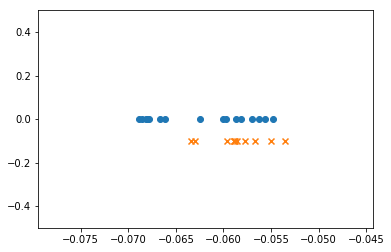

In [10]:
_, ytruestrain, scorestrain = rtrain

sstrain = np.concatenate(scorestrain).T

xsminustrain = [sstrain[0][i] for i in range(len(ytruestrain)) if ytruestrain[i] == 0]
plt.scatter(xsminustrain, [0]*len(xsminustrain), marker = 'o')
xsplustrain = [sstrain[0][i] for i in range(len(ytruestrain)) if ytruestrain[i] == 1]
plt.scatter(xsplustrain, [-.1]*len(xsplustrain), marker = 'x')
# plt.xlim([-0.09, -0.05])
plt.ylim([-.5, .5])
plt.show()

In [12]:
def plot_ROCs(y_score, y_true):
    fig = plt.figure(figsize=(6, 6))
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    print(auc)
    plt.plot(fpr, tpr, lw=2, c='r', alpha=0.8)#, label = r'%s (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC curve")
    plt.legend(loc="lower right")
    plt.show()


0.6875


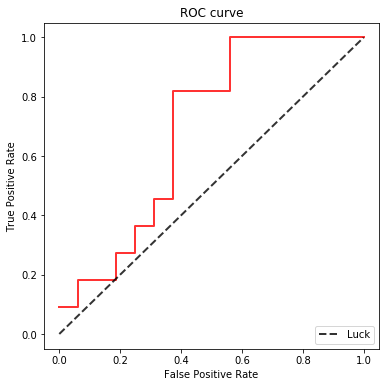

In [13]:
plot_ROCs(sstrain[0], ytruestrain)

In [19]:
sort_scores = sorted(range(27), key=lambda x:sstrain[0][x])
sort_scores

[11,
 20,
 16,
 12,
 19,
 15,
 24,
 21,
 9,
 23,
 2,
 22,
 13,
 5,
 18,
 26,
 0,
 8,
 25,
 17,
 6,
 1,
 3,
 10,
 4,
 14,
 7]

In [20]:
sort_trues = np.array(ytruestrain)[sort_scores]
sort_trues

array([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 1., 0., 1.], dtype=float32)

In [21]:
for bar in range(27):
    print((sum(sort_trues[:bar]==0) + sum(sort_trues[bar:]==1)) / 22.)

0.5
0.5454545454545454
0.5909090909090909
0.6363636363636364
0.6818181818181818
0.7272727272727273
0.7727272727272727
0.8181818181818182
0.7727272727272727
0.7272727272727273
0.7727272727272727
0.8181818181818182
0.8636363636363636
0.8181818181818182
0.7727272727272727
0.7272727272727273
0.6818181818181818
0.7272727272727273
0.6818181818181818
0.7272727272727273
0.6818181818181818
0.7272727272727273
0.6818181818181818
0.7272727272727273
0.7727272727272727
0.7272727272727273
0.7727272727272727


## Run predictions w/ dropout

In [98]:
ytrues = []
yscores = []

In [102]:
for i in range(9):
    print(i)
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, config.ckpt_path)
        rtrain = model.run_test(sess, "train_dropout")

        _, ytruestrain, scorestrain = rtrain
        sstrain = np.concatenate(scorestrain).T[0]

        ytrues.extend(ytruestrain)
        yscores.extend(list(sstrain))

0
INFO:tensorflow:Restoring parameters from ckpt/miccai_classifier_v0.ckpt

Validation ...


/home/marcthib/miniconda3/envs/myenv/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/marcthib/miniconda3/envs/myenv/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


6
25
3
2/6 [=========>....................] - ETA: 15s29
13
4/6 [===================>..........] - ETA: 6s 7
27
6/6 [==============================] - 17s    
5
22
8/6 [========================================] - 23s
20
31
10/6 [==================================================] - 27s
19
15
2
12/6 [============================================================] - 32s
32
24
14/6 [======================================================================] - 37s
21
16/6 [================================================================================] - 42s
4
17
12
18/6 [==========================================================================================] - 47s
30
28
22/6 [==============================================================================================================] - 56s
-- run_test -- 
-- ytrues = [0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0] -- 
-- ypreds = [False, False, False, False, False, False, Fals

12/6 [============================================================] - 34s
32
24
14/6 [======================================================================] - 38s
21
16/6 [================================================================================] - 43s
4
17
12
18/6 [==========================================================================================] - 48s
30
20/6 [====================================================================================================] - 53s
28
22/6 [==============================================================================================================] - 57s
-- run_test -- 
-- ytrues = [0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0] -- 
-- ypreds = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False] -- 
-- scores = [array([[-0.07274485],
       [-0.05831055]], dtype=float

0.6428571428571428


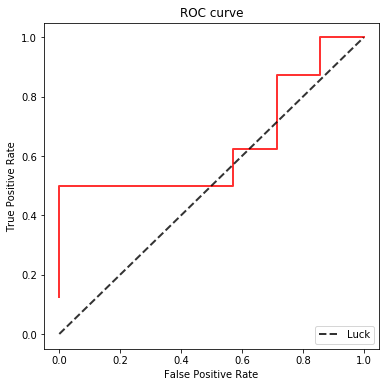

In [103]:
plot_ROCs(yscores, ytrues)

## Run features extraction

In [22]:
all_ytrues = []
all_feats = []
all_ids = []

In [23]:
for i in tqdm_notebook(range(10)):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, config.ckpt_path)
        rtrain = model.run_features(sess, "train_dropout", dropout = True)
        ytrues, feats, ids = rtrain

        all_ytrues.extend(ytrues)
        all_feats.extend(feats)
        all_ids.extend(ids)

INFO:tensorflow:Restoring parameters from ckpt/miccai_classifier_v1.ckpt

Validation ...


/home/marcthib/miniconda3/envs/myenv/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/marcthib/miniconda3/envs/myenv/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


12
5
24
28
2/6 [=========>....................] - ETA: 20s15
21
4/6 [===================>..........] - ETA: 9s 4
23
6/6 [==============================] - 26s    
3
8/6 [========================================] - 35s
30
27
11
10/6 [==================================================] - 44s
20
12/6 [============================================================] - 52s
7
6
19
14/6 [======================================================================] - 61s
16
14
16/6 [================================================================================] - 69s
29
2
18/6 [==========================================================================================] - 78s
17
32
20/6 [====================================================================================================] - 86s
13
10
22/6 [==============================================================================================================] - 95s
31
25
24/6 [======================================================================

In [65]:
feats = np.concatenate(all_feats, axis=0)
# feats = feats[:, :2]
ytrues = np.concatenate(all_ytrues, axis=0)
ids = np.concatenate(all_ids, axis=0)

Run SVM

In [25]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [57]:
r = SVC(class_weight='balanced', probability=True)

In [47]:
r = LogisticRegression(class_weight='balanced')

In [52]:
r = LogisticRegression()

In [58]:
r.fit(feats, ytrues)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [59]:
r.score(feats, ytrues)

0.4074074074074074

0.6125568181818182


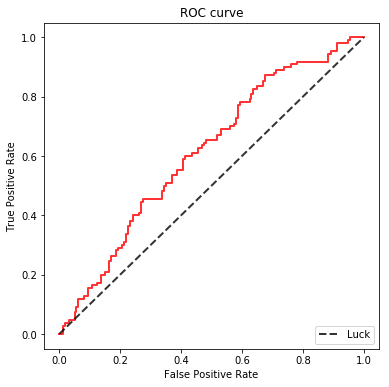

In [60]:
plot_ROCs(r.predict_proba(feats)[:, 0], ytrues)

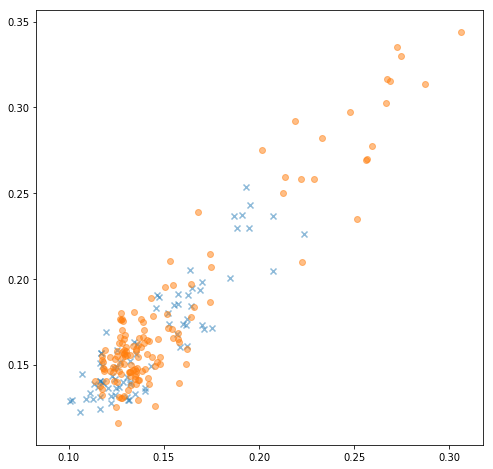

In [105]:
plt.figure(figsize=(8, 8))
plt.scatter([feats[i][0] for i in range(220) if ytrues[i]],
            [feats[i][1] for i in range(220) if ytrues[i]], marker="x", alpha=.5)
plt.scatter([feats[i][0] for i in range(220) if not ytrues[i]],
            [feats[i][1] for i in range(220) if not ytrues[i]], marker="o", alpha=.5)

In [66]:
feats.shape

(270, 64)

In [67]:
ytrues.shape

(270,)

In [68]:
ids.shape

(270,)

In [80]:
subids = [i for i in range(10) for l in range(27)]

In [73]:
import pandas as pd

In [86]:
d = {"feat_radio_"+str(i): feats[:, i] for i in range(64)}
d["ids"] = ids
d["subids"] = subids
d["ytrue"] = ytrues
feats_df = pd.DataFrame(data=d).set_index(["ids", "subids"]).sort_index()
feats_df

feat_radio_0  feat_radio_1  feat_radio_10  feat_radio_11  \
ids subids                                                             
2   0           0.109204      0.001364       0.004211       0.079439   
    1           0.106394      0.000984       0.006510       0.075854   
    2           0.108518      0.000734       0.005787       0.080568   
    3           0.100031      0.000607       0.004356       0.088266   
    4           0.111571      0.001089       0.004684       0.082056   
    5           0.096399      0.001190       0.003917       0.071836   
    6           0.101365      0.000742       0.005080       0.078599   
    7           0.106751      0.000450       0.004234       0.066684   
    8           0.105062      0.001548       0.005981       0.082623   
    9           0.102574      0.001091       0.004535       0.072930   
3   0           0.120322      0.000603       0.006010       0.085475   
    1           0.103816      0.001499       0.007279       0.085366   
    2           0.124463      0.000571       0.007859       0.088110   
    3           0.119423      0.001286       0.004444       0.088076   
    4           0.107377      0.000747       0.005477       0.087065   
    5           0.123132      0.000963       0.006737       0.092273   
    6           0.119494      0.000941       0.005011       0.094767   
    7           0.106122      0.001302       0.006205       0.079275   
    8           0.115893      0.000680       0.006182       0.076619   
    9           0.109004      0.000536       0.006399       0.090105   
4   0           0.111212      0.000614       0.005078       0.089330   
    1           0.118017      0.002568       0.008579       0.074601   
    2           0.104974      0.001430       0.004165       0.085364   
    3           0.121392      0.001420       0.006987       0.083209   
    4           0.118257      0.001469       0.004232       0.082223   
    5           0.119467      0.000800       0.005266       0.077249   
    6           0.118997      0.001162       0.005014       0.082564   
    7           0.127995      0.000794       0.005019       0.081839   
    8           0.104352      0.000588       0.003974       0.082859   
    9           0.115914      0.000744       0.004563       0.083345   
...                  ...           ...            ...            ...   
30  0           0.132297      0.001851       0.006356       0.095855   
    1           0.117427      0.001168       0.007596       0.085117   
    2           0.137537      0.000879       0.007830       0.084179   
    3           0.113115      0.000858       0.007545       0.091995   
    4           0.120537      0.000989       0.006513       0.093625   
    5           0.099888      0.000727       0.004922       0.081608   
    6           0.107268      0.001220       0.007657       0.091045   
    7           0.114145      0.001004       0.005221       0.100031   
    8           0.120378      0.001087       0.005675       0.084094   
    9           0.119632      0.000431       0.007393       0.088641   
31  0           0.111221      0.000266       0.004570       0.086752   
    1           0.117712      0.000688       0.003831       0.095130   
    2           0.115218      0.000478       0.004089       0.081269   
    3           0.109977      0.001724       0.005135       0.082633   
    4           0.105757      0.000577       0.005151       0.077070   
    5           0.112043      0.001000       0.003522       0.070576   
    6           0.122872      0.000909       0.006875       0.078190   
    7           0.101423      0.000262       0.005652       0.084366   
    8           0.127581      0.001649       0.003788       0.092674   
    9           0.100196      0.000628       0.006589       0.084183   
32  0           0.080172      0.001116       0.004180       0.066451   
    1           0.101343      0.000423       0.004968       0.064908   
    2           0.088675      0.000905       0.00584

In [88]:
feats_df.to_csv("data/features_radiology.csv")